# Neocortical Microcircuit 

[Portal](https://bbp.epfl.ch/nmc-portal/welcome)

Digital Reconstruction of Neocortical Microcircuit

In [ ]:
import os
os.unsetenv('PYTHONHOME') 
!pip install -q bluepyopt==1.5.12 matplotlib==2.0.2 numpy==1.13.0 neurom==1.4.2 2>&1 | grep -v 'SNIMissingWarning\|InsecurePlatformWarning'

%matplotlib inline
import matplotlib.pyplot as pyplot

import os
import zipfile       # Extract zip files
import urllib        # Download files from the web
import neurom        # Analyse / view morphologies
import neurom.viewer

Select a model from the [portal](https://bbp.epfl.ch/nmc-portal/microcircuit#/metype/L5_TTPC2_cADpyr/details) and download

In [ ]:
urllib.urlretrieve('https://bbp.epfl.ch/nmc-portal/documents/10184/1921755/L5_TTPC2_cADpyr232_1.zip/a058fc9c-6c67-417b-a65b-20742902ccbb','L5_TTPC2_cADpyr232_1.zip');

import os, zipfile
with zipfile.ZipFile('L5_TTPC2_cADpyr232_1.zip', 'r') as zip_file:
    zip_file.extractall('.')
    
os.chdir('L5_TTPC2_cADpyr232_1')

!nrnivmodl mechanisms

## Morphology Visualisation

In [ ]:
neurom.viewer.draw(neurom.load_neuron('morphology/dend-C060114A7_axon-C060116A3_-_Clone_2.asc'));

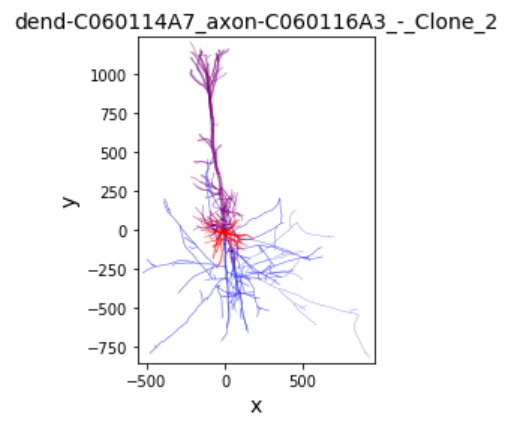

In [ ]:
import neuron as nrn 
nrn.h.load_file("./init.hoc");

nrn.h.create_cell(1);

cell = nrn.h.cell
soma = cell.soma[0]

## Inject a step current

In [ ]:
stimulus = nrn.h.IClamp(0.5, sec=soma)
stimulus.dur = 400 
stimulus.delay = 100     
stimulus.amp = 0.691907

In [ ]:
with open('current_amps.dat') as current_file:
    current_content = current_file.read()

print 'File content: ', current_content
holding_current, step1_current, step2_current, step3_current = [float(x) for x in current_content.split()]

print
print 'Holding current: %f nA' % holding_current
print 'Step 1: %f nA' % step1_current
print 'Step 2: %f nA' % step2_current
print 'Step 3: %f nA' % step3_current 

In [ ]:
#recording of activity

nrn.h.create_recording();

nrn.h.tstop = 600 # ms
nrn.h.dt = 0.05 # 
nrn.h.run();

nrn.h.save_recording();

In [ ]:
time = nrn.h.time
voltage = nrn.h.voltage

def plot_tv(time_array, voltage_array, show=True, label=None, constants=[]):
    import matplotlib.pyplot as plt
    import numpy
    plt.plot(time_array, voltage_array, label=label)
    for constant in constants:
        plt.plot(time_array, constant*numpy.ones(len(time_array)))
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane voltage (mV)')
    if show:
        plt.show()
    

plot_tv(time, voltage);

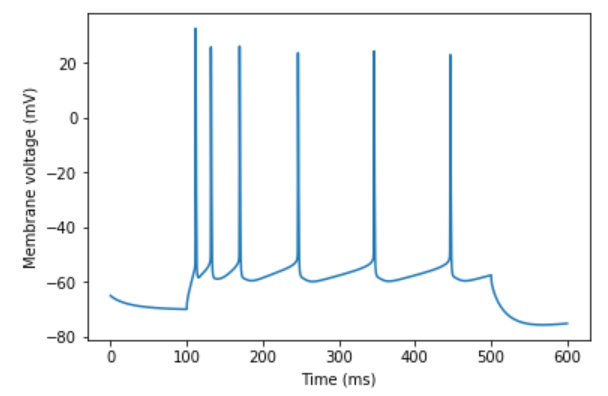

## Synapse Activation

In [ ]:
print "Number of synapses: ", len(list(cell.synapses.synapse_list))

print "Number of pre-synaptic cells: ", len(list(cell.synapses.netstim_list))

with open('synapses/mtype_map.tsv') as mtype_map_file:
    mtype_map_content = mtype_map_file.read()
print 'integer\tm-type'
print '---------------'
print mtype_map_content

In [ ]:
mtype_map = {}
for line in mtype_map_content.split('\n')[:-1]:
    n, mtype = line.split()
    mtype_map[mtype] = int(n)
    
print 'Integer for L23_PC: %d' % mtype_map['L23_PC']

In [ ]:
# enable all the synapses that are projected onto this cell from L23_PC (layer 2/3 pyramidal cell)

def init_synapses(enabled_mtypes=[]):
    enabled_mtype_ints = [mtype_map[mtype] for mtype in enabled_mtypes]
    
    for i in range(0, int(cell.synapses.n_of_mtypes)): # Loop over all the m-type
        if i in enabled_mtype_ints: # Enable synapses
            cell.synapses.were_active_pre_mtypes.x[i]= 0
            cell.synapses.active_pre_mtypes.x[i] = 1        
        else: # Disable synapses
            cell.synapses.were_active_pre_mtypes.x[i]= 1
            cell.synapses.active_pre_mtypes.x[i] = 0
            
    cell.synapses.update_synapses(nrn.h.synapse_plot); # Update the synapses

init_synapses(enabled_mtypes=['L23_PC'])

In [ ]:
# Remove any previously defined stimulus
if 'stimulus' in locals():
    del stimulus

def run_plot():
    nrn.h.tstop = 600
    nrn.h.dt = 0.05

    nrn.h.run()
    nrn.h.save_recording()

    plot_tv(time, voltage)
    
run_plot()

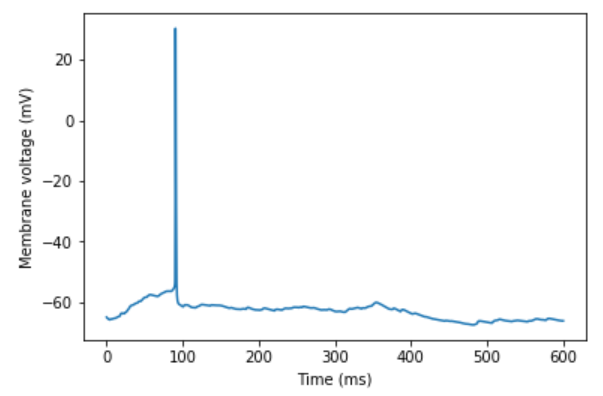

In [ ]:
#Layer 5 Thick Tufted Pyramidal cell connections activation

init_synapses(enabled_mtypes=['L5_TTPC2'])
run_plot()

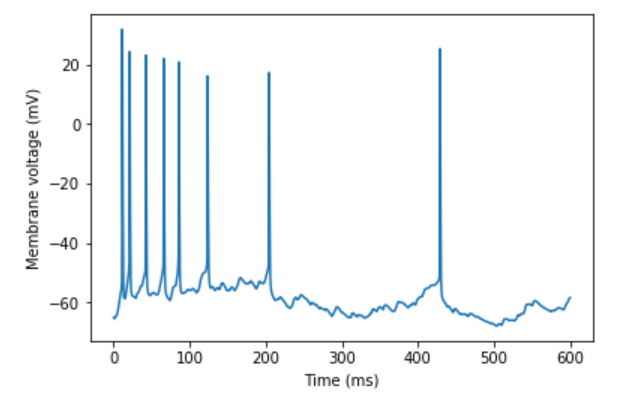

In [ ]:
#activating some inhibitory interneurons together with the excitatory input

init_synapses(enabled_mtypes=['L23_PC', 'L23_MC', 'L23_BTC', 'L23_LBC', 'L23_SBC', 'L23_DBC'])
run_plot()

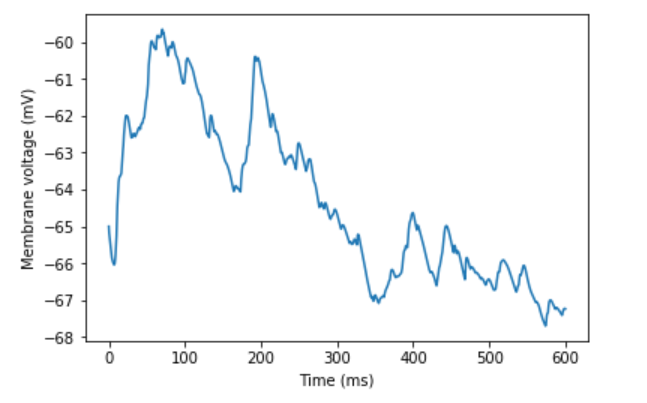

In [ ]:
#influence parameters e.g. the poisson processes that are creating the spike timings of the presynaptic cells

init_synapses(enabled_mtypes=['L5_TTPC2'])

pre_mtype_netstims = list(cell.synapses.pre_mtype_netstimlists)

for netstims in pre_mtype_netstims:
    for netstim in netstims: 
        netstim.interval = 10000 # ms, Average interval between spikes in the Poisson process   

run_plot()

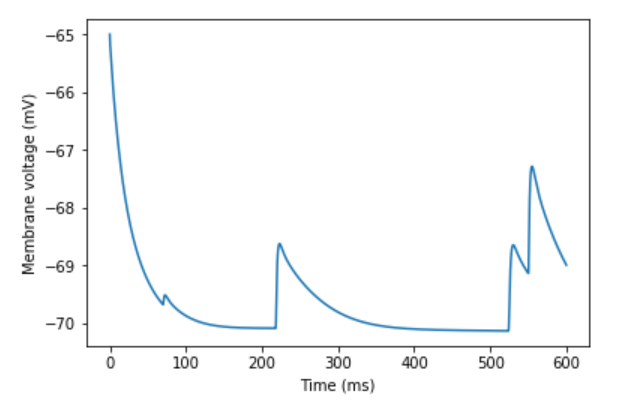